## 深度学习基础

矢量计算表达式

In [10]:
import torch
from time import  time

a = torch.ones(1000)
b = torch.ones(1000)

In [12]:
start = time()
c = torch.zeros(1000)
for i in range(1000):
    c[i] = a[i] + b[i]
print(time() - start)

0.013412952423095703


In [13]:
start = time()
d = a + b
print(time() - start)

0.00014138221740722656


In [14]:
a = torch.ones(3)
b = 10
print(a + b)

tensor([11., 11., 11.])


#### 3.2 线性回归的从零开始实现

In [15]:
%matplotlib inline
import torch
from IPython import display
from matplotlib import pyplot as plt
import numpy as np
import random

In [16]:
num_inputs = 2
num_examples = 1000
true_w = [2,-3.4]
true_b = 4.2
features = torch.randn(num_examples,num_inputs,dtype=torch.float32)
labels = true_w[0] * features[:,0] + true_w[1] * features[:,1] + true_b
labels += torch.tensor(np.random.normal(0,0.01,size=labels.size()),dtype=torch.float32)

In [17]:
print(features[0],labels[0])

tensor([ 0.0832, -1.2534]) tensor(8.6369)


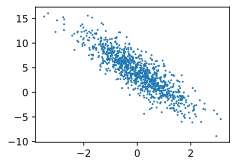

In [18]:
def use_svg_displty():
    # 用矢量图显示
    display.set_matplotlib_formats('svg')

def set_figsize(figsize=(3.5,2.5)):
    use_svg_displty()
    # 设置图的尺寸
    plt.rcParams['figure.figsize'] = figsize

set_figsize()
plt.scatter(features[:,1].numpy(),labels.numpy(),1)


读取数据

In [19]:
def data_iter(batch_size,features,labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    random.shuffle(indices)  #样本的读取顺序是随机的
    for i in range(0,num_examples,batch_size):
        j = torch.LongTensor(indices[i:min(i + batch_size,num_examples)])
        yield features.index_select(0,j),labels.index_select(0,j)

In [20]:
batch_size = 10

for X,y in data_iter(batch_size,features,labels):
    print(X,y)
    break

tensor([[ 0.2452, -0.6472],
        [-0.7148,  0.7142],
        [ 0.2315, -0.1395],
        [ 1.9127,  1.3774],
        [-1.2121, -0.3030],
        [-0.0111,  0.4736],
        [ 2.2024, -0.7703],
        [-0.1329,  0.0502],
        [ 1.6609, -0.8204],
        [ 0.6825,  0.4923]]) tensor([ 6.9041,  0.3440,  5.1325,  3.3586,  2.7951,  2.5598, 11.2255,  3.7622,
        10.3366,  3.8889])


初始化模型参数

In [21]:
w = torch.tensor(np.random.normal(0,0.01,(num_inputs,1)),dtype=torch.float32)
b = torch.zeros(1,dtype=torch.float32)

In [22]:
w.requires_grad_(requires_grad=True)
b.requires_grad_(requires_grad=True)

tensor([0.], requires_grad=True)

定义模型

In [23]:
def linreg(X,w,b):
    return torch.mm(X,w) + b

定义损失函数

In [24]:
def squared_loss(y_hat,y):
    #这里返回的是向量，另外，pytorch里的MSELoss没有除以2
    return (y_hat - y.view(y_hat.size())) ** 2 / 2

定义优化算法

In [25]:
def sgd(params,lr,batch_size):
    for param in params:
        param.data -= lr * param.grad /batch_size # 这里更改param时用的param.data

训练模型

In [27]:
lr = 0.03
num_epochs = 3
net = linreg  # 函数指针
loss = squared_loss # 函数指针

for epoch in range(num_epochs):
    for X,y in data_iter(batch_size,features,labels):
        l = loss(net(X,w,b),y).sum()
        l.backward() # 小批量的损失对模型参数求梯度
        sgd([w,b],lr,batch_size)

        w.grad.data.zero_()
        b.grad.data.zero_()
    
    train_l = loss(net(features,w,b),labels)
    print("epoch %d,loss %f"% (epoch + 1,train_l.mean().item()))



epoch 1,loss 0.039651
epoch 2,loss 0.000139
epoch 3,loss 0.000050


In [28]:
print(true_w,'\n',w)
print(true_b,'\n',b)

[2, -3.4] 
 tensor([[ 1.9998],
        [-3.3996]], requires_grad=True)
4.2 
 tensor([4.1992], requires_grad=True)


#### 3.3 线性回归简洁实现

生成数据集

In [47]:
num_inputs = 2
num_examples = 1000
true_w = [2,-3.4]
true_b = 4.2
features = torch.tensor(np.random.normal(0,1,(num_examples,num_inputs)),dtype=torch.float)
labels = true_w[0] * features[:,0] + true_w[1] * features[:,1] + true_b
labels += torch.tensor(np.random.normal(0,0.01,size=labels.size()),dtype=torch.float)

读取数据

In [48]:

import torch.utils.data as Data

batch_size = 10
# 将训练数据的特征和标签组合
dataset = Data.TensorDataset(features,labels)
# 随机读取小批量
data_iter = Data.DataLoader(dataset,batch_size,shuffle=True)

In [49]:
for X,y in data_iter:
    print(X,y)
    break

tensor([[-0.1036, -0.1943],
        [ 0.4149,  0.4722],
        [ 1.0552,  2.2486],
        [ 0.4291,  0.4056],
        [-0.3473, -0.4569],
        [-0.6925, -0.7922],
        [ 1.4294, -0.2466],
        [-1.1928, -0.1574],
        [-2.1017,  0.4596],
        [ 0.1161,  1.9290]]) tensor([ 4.6554,  3.4330, -1.3409,  3.6883,  5.0452,  5.5135,  7.9116,  2.3453,
        -1.5807, -2.1066])


定义模型

In [50]:
from torch import nn
class LinearNet(nn.Module):
    def __init__(self,n_feature) -> None:
        super(LinearNet,self).__init__()
        self.linear = nn.Linear(n_feature,1)
    
    # forward定义前向传播
    def forward(self,x):
        y = self.linear(x)
        return y

net = LinearNet(num_inputs)
print(net)

LinearNet(
  (linear): Linear(in_features=2, out_features=1, bias=True)
)


In [53]:
net = nn.Sequential(
    nn.Linear(num_inputs,1)
    # 此处还可以传入其他层
)

# net = nn.Sequential()
# net.add_module('linear',nn.Linear(num_inputs,1))

# from collections import OrderedDict
# net = nn.Sequential(OrderedDict([
#     ('linear',nn.Linear(num_inputs,1))
# ]))

# print(net)
# print(net[0])

In [54]:
for param in net.parameters():
    print(param)

Parameter containing:
tensor([[ 0.3834, -0.6188]], requires_grad=True)
Parameter containing:
tensor([-0.2888], requires_grad=True)


初始化模型参数

In [55]:
from torch.nn import init

init.normal_(net[0].weight,mean=0,std=0.01)
init.constant_(net[0].bias,val=0)

Parameter containing:
tensor([0.], requires_grad=True)

定义损失函数

loss = nn.MSELoss()

定义优化算法

In [40]:
import torch.optim as optim

optimizer = optim.SGD(net.parameters(),lr=0.03)
print(optimizer)

SGD (
Parameter Group 0
    dampening: 0
    lr: 0.03
    momentum: 0
    nesterov: False
    weight_decay: 0
)


In [43]:
#optimizer = optim.SGD([
#    {'param':net.subnet1.parameters()},
#    {'params':net.subnet2.parameters(),'lr':0.01}
#])

In [44]:
for param_group in optimizer.param_groups:
    param_group['lr'] *= .1

训练模型

In [57]:
num_epochs = 3
for epoch in range(1,num_epochs + 1):
    for X,y in data_iter:
        output = net(X)
        l = loss(output,y.view(-1,1))
        optimizer.zero_grad()
        l.backward()
        optimizer.step()
    print("epoch %d,loss: %f"%(epoch,l.item()))

RuntimeError: grad can be implicitly created only for scalar outputs